In [78]:
import tensorflow as tf
import madmom
import numpy as np
from modules.analysis_funcs import get_segmented_data, get_test_peaks
import mir_eval
import matplotlib.pyplot as plt
import pickle

In [83]:
MODEL_PATH = "results/cnn-training-230202j/fold_0_refined-seq-200eps-lr0.0010-standard_model"
HIST_PATH = "results/cnn-training-230202j/fold_0_refined-seq-200eps-lr0.0010-standard_history.pickle"
with open(HIST_PATH, "rb") as f:
    history = pickle.load(f)
model = tf.keras.models.load_model(MODEL_PATH, custom_objects = {"wbce": lambda x,y:None})

In [144]:
c1 = MODEL_PATH[:-6]+"_cp_{:04d}.ckpt".format(40)
c2 = MODEL_PATH[:-6]+"_cp_{:04d}.ckpt".format(100)

In [145]:
audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
audio, sample_rate = madmom.io.audio.load_audio_file(audio_fname)

label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"
true_onsets = np.loadtxt(label_fname, usecols=0)


TOL = 0.025
FPS = 100
framerate = 1/FPS
W = 40

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [146]:
from modules.labels import get_label_vector
true_onset_vector = get_label_vector(true_onsets, len(audio)/sample_rate, FPS)

In [257]:
model.load_weights(c1)
cnn_input = get_segmented_data(audio)
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, framerate)

In [258]:
mir_eval.onset.evaluate(true_onsets, cnn_onsets, window=TOL)
from analyze_detection import evaluate
[CD,FN,FP,doubles,merged] = evaluate(true_onsets, cnn_onsets, tol_sec=TOL)
# Between c1 and c2 we get lower recall and higher precision = More FNs and fewer FPs


In [259]:
print("FN: ", FN)
print("FP: ", FP)

FN:  34
FP:  3


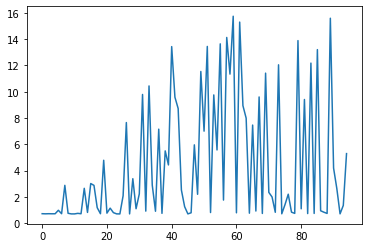

In [264]:
def wbce(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1-1e-7)
        logits = tf.keras.backend.log(y_pred/(1-y_pred))
        return tf.nn.weighted_cross_entropy_with_logits(
            y_true, logits, W
)
def sigmoid(x):
    return 1/(1+np.exp(-x))

pos_idx = np.where(true_onset_vector==1)[0]
neg_idx = np.where(true_onset_vector==0)[0]

logits = np.reshape(cnn_output/(1-cnn_output), (-1))

#some_logits = logits[np.where(true_onset_vector==1)[0]]
plt.plot(-np.log(1-sigmoid(logits))[pos_idx])
#plt.scatter(np.arange(1000), true_onset_vector[1000:2000])

In [261]:


tp_cost = np.mean(-np.log(sigmoid(logits))[pos_idx])
tn_cost = np.mean(-np.log(1-sigmoid(logits))[neg_idx])
fp_cost = np.mean(-np.log(1-sigmoid(logits))[pos_idx])
fn_cost = np.mean(-np.log(sigmoid(logits))[neg_idx])

In [262]:
print(tp_cost, tn_cost, fp_cost, fn_cost)


0.3012832661280991 0.8043644326370889 4.334505358082541 0.6749938697795578
0.0011661226023316716


array([4.02047168e-02, 2.22403069e-02, 3.84529118e-02, 2.80389232e-02,
       3.04821619e-02, 4.99223878e-01, 3.98352293e-02, 2.81365924e+00,
       1.01251440e-01, 1.01066897e-02, 9.32381915e-03, 9.02115977e-02,
       3.50759662e-02, 2.57017969e+00, 2.22908651e-01, 2.95830283e+00,
       2.80956284e+00, 8.00204872e-01, 3.61787485e-02, 4.77076418e+00,
       1.22387655e-01, 7.48034900e-01, 1.92646607e-01, 1.37844088e-02,
       7.29980018e-03, 1.94912725e+00, 7.64982388e+00, 8.98554710e-03,
       3.34173728e+00, 6.82221211e-01, 2.10995648e+00, 9.78639792e+00,
       3.94019864e-01, 1.04354007e+01, 2.82964783e+00, 3.78676297e-01,
       7.14566550e+00, 9.06035964e-02, 5.48855462e+00, 4.41278427e+00,
       1.34294449e+01, 9.57874620e+00, 8.71851474e+00, 2.43032057e+00,
       9.08525805e-01, 1.17552140e-02, 1.72604555e-01, 5.94951839e+00,
       2.07147990e+00, 1.15360528e+01, 6.99457518e+00, 1.34419711e+01,
       2.07106840e-01, 9.75111814e+00, 5.56111940e+00, 1.36385058e+01,
      

In [127]:
bce = np.mean(true_onset_vector * -np.log(sigmoid(logits)) + (1 - true_onset_vector) * -np.log(1 - sigmoid(logits)))

0.42580160926465177

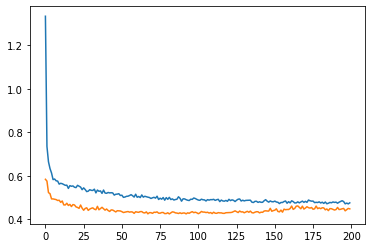

In [143]:
plt.plot(history["loss"])
plt.plot(history["val_wbce"])

In [163]:
history["loss"][20]*len(cnn_output)/len(true_onsets)

30.12791326653354

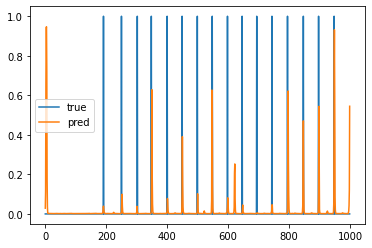

In [53]:

plt.plot(true_onset_vector[:1000])
plt.plot(cnn_output[:1000])
plt.legend(["true", "pred"])

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a int64 tensor but is a double tensor [Op:Mul]

5244